In [26]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
# Aplicação do HDBSCAN
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [27]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5","exams_part12.hdf5", "exams_part13.hdf5", "exams_part10.hdf5", "exams_part11.hdf5","exams_part9.hdf5", "exams_part8.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == True) & 
                                (dados.iloc[:, 5] == False ) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 9] == False)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == True) & 
                                (dados.iloc[:, 5] == False ) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 9] == False)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:10000]

ids_ecgs = ecg_doente_id + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 73700
Número de linhas ecg_doente_linhas: 2190
Tirando Interferência:
Número de linhas ecg_normal_linhas: 71713
Número de linhas ecg_doente_linhas: 2150
Número de ecgs pra clusterizar: 12150


In [28]:
# Função para obter dados de ECG de um arquivo HDF5
def get_ecg_data(file_paths, exam_id):
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) != 0:
                exam_index = exam_index[0]
                exam_tracings = f['tracings'][exam_index]
                return exam_tracings
    raise ValueError("Exam ID não encontrado em nenhum dos arquivos fornecidos.")

# Caminhos para os arquivos HDF5
file_paths = ['../Database/filtered_exams_14_15.hdf5', '../Database/filtered_exams_16_17.hdf5','../Database/filtered_exams_12_13.hdf5', '../Database/filtered_exams_10_11.hdf5','../Database/filtered_exams_8_9.hdf5']



# Obter os tracings de ECG para cada exam_id e armazenar na lista
all_tracings = []
for exam_id in ids_ecgs:
    tracings = get_ecg_data(file_paths, exam_id)
    #Selecionar as leads V1 (índice 6) e V6 (índice 11)
    lead_v1 = tracings[:, 6]
    lead_v6 = tracings[:, 11]
    #lead_d2 = tracings[:, 6]
    #lead_d1 = tracings[:, 11]
    #Combinar as leads V1 e V6 em uma única dimensão
    combined_leads = np.concatenate((lead_v1, lead_v6))
    all_tracings.append(combined_leads)

# Converter lista para array numpy
X = np.array(all_tracings)

print("Shape de X para o autoencoder:", X.shape)
# X agora está pronto para ser usado no autoencoder

Shape de X para o autoencoder: (12150, 8192)


In [ ]:
# Índice desejado
index = 8

# Verifique se o índice está dentro dos limites da lista
if index < len(ids_ecgs):
    exam_id = ids_ecgs[index]
    print("O ID do exame no índice 11700 é:", exam_id)
else:
    print("O índice está fora dos limites da lista de IDs de exames.")

# Plotar os dados de ECG para o índice desejado
plt.plot(X[index])
plt.title(f"ECG Lead V1 for Exam ID: {exam_id}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=40, kernel_size=8, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(40)
        self.conv2 = nn.Conv1d(in_channels=40, out_channels=20, kernel_size=8, stride=2, padding=3)
        self.bn2 = nn.BatchNorm1d(20)
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=8, stride=2, padding=3)
        self.bn3 = nn.BatchNorm1d(20)
        self.conv4 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=8, stride=2, padding=3)
        self.bn4 = nn.BatchNorm1d(20)
        self.conv5 = nn.Conv1d(in_channels=20, out_channels=40, kernel_size=8, stride=2, padding=3)
        self.bn5 = nn.BatchNorm1d(40)
        self.conv6 = nn.Conv1d(in_channels=40, out_channels=1, kernel_size=8, stride=2, padding=3)

    def forward(self, x):
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = F.elu(self.bn5(self.conv5(x)))
        x = self.conv6(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose1d(in_channels=1, out_channels=40, kernel_size=8, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(40)
        self.deconv2 = nn.ConvTranspose1d(in_channels=40, out_channels=20, kernel_size=8, stride=2, padding=3)
        self.bn2 = nn.BatchNorm1d(20)
        self.deconv3 = nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=8, stride=2, padding=3)
        self.bn3 = nn.BatchNorm1d(20)
        self.deconv4 = nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=8, stride=2, padding=3)
        self.bn4 = nn.BatchNorm1d(20)
        self.deconv5 = nn.ConvTranspose1d(in_channels=20, out_channels=40, kernel_size=8, stride=2, padding=3)
        self.bn5 = nn.BatchNorm1d(40)
        self.deconv6 = nn.ConvTranspose1d(in_channels=40, out_channels=1, kernel_size=8, stride=2, padding=3)

    def forward(self, x):
        x = F.elu(self.bn1(self.deconv1(x)))
        x = F.elu(self.bn2(self.deconv2(x)))
        x = F.elu(self.bn3(self.deconv3(x)))
        x = F.elu(self.bn4(self.deconv4(x)))
        x = F.elu(self.bn5(self.deconv5(x)))
        x = self.deconv6(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [24]:
import torch

if torch.cuda.is_available():
    print(f"CUDA está disponível. Número de GPUs: {torch.cuda.device_count()}")
    print(f"GPU atual: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA não está disponível. Verifique a instalação do CUDA e dos drivers da GPU.")


CUDA está disponível. Número de GPUs: 1
GPU atual: NVIDIA GeForce RTX 3090 Ti


Formato original de X: (12150, 8192)
Formato antes do reshape: (12150, 8192)
Formato após o reshape: (12150, 1, 8192)
Número total de elementos: 99532800


Epoch 1/60:   8%|▊         | 23/304 [00:00<00:01, 220.16it/s]

Epoch 1/60: 100%|██████████| 304/304 [00:01<00:00, 226.26it/s]


Epoch 1, Train Loss: 0.0633, Validation Loss: 0.0126


Epoch 2/60: 100%|██████████| 304/304 [00:01<00:00, 225.99it/s]


Epoch 2, Train Loss: 0.0119, Validation Loss: 0.0115


Epoch 3/60: 100%|██████████| 304/304 [00:01<00:00, 226.24it/s]


Epoch 3, Train Loss: 0.0106, Validation Loss: 0.0097


Epoch 4/60: 100%|██████████| 304/304 [00:01<00:00, 228.92it/s]


Epoch 4, Train Loss: 0.0085, Validation Loss: 0.0075


Epoch 5/60: 100%|██████████| 304/304 [00:01<00:00, 227.98it/s]


Epoch 5, Train Loss: 0.0068, Validation Loss: 0.0066


Epoch 6/60: 100%|██████████| 304/304 [00:01<00:00, 228.81it/s]


Epoch 6, Train Loss: 0.0056, Validation Loss: 0.0048


Epoch 7/60: 100%|██████████| 304/304 [00:01<00:00, 227.98it/s]


Epoch 7, Train Loss: 0.0047, Validation Loss: 0.0042


Epoch 8/60: 100%|██████████| 304/304 [00:01<00:00, 228.87it/s]


Epoch 8, Train Loss: 0.0042, Validation Loss: 0.0037


Epoch 9/60: 100%|██████████| 304/304 [00:01<00:00, 228.03it/s]


Epoch 9, Train Loss: 0.0038, Validation Loss: 0.0034


Epoch 10/60: 100%|██████████| 304/304 [00:01<00:00, 228.82it/s]


Epoch 10, Train Loss: 0.0034, Validation Loss: 0.0032


Epoch 11/60: 100%|██████████| 304/304 [00:01<00:00, 227.98it/s]


Epoch 11, Train Loss: 0.0032, Validation Loss: 0.0034


Epoch 12/60: 100%|██████████| 304/304 [00:01<00:00, 227.12it/s]


Epoch 12, Train Loss: 0.0029, Validation Loss: 0.0028


Epoch 13/60: 100%|██████████| 304/304 [00:01<00:00, 227.89it/s]


Epoch 13, Train Loss: 0.0028, Validation Loss: 0.0026


Epoch 14/60: 100%|██████████| 304/304 [00:01<00:00, 227.15it/s]


Epoch 14, Train Loss: 0.0027, Validation Loss: 0.0025


Epoch 15/60: 100%|██████████| 304/304 [00:01<00:00, 227.17it/s]


Epoch 15, Train Loss: 0.0026, Validation Loss: 0.0023


Epoch 16/60: 100%|██████████| 304/304 [00:01<00:00, 226.75it/s]


Epoch 16, Train Loss: 0.0025, Validation Loss: 0.0024


Epoch 17/60: 100%|██████████| 304/304 [00:01<00:00, 226.87it/s]


Epoch 17, Train Loss: 0.0024, Validation Loss: 0.0023


Epoch 18/60: 100%|██████████| 304/304 [00:01<00:00, 227.05it/s]


Epoch 18, Train Loss: 0.0024, Validation Loss: 0.0025


Epoch 19/60: 100%|██████████| 304/304 [00:01<00:00, 226.92it/s]


Epoch 19, Train Loss: 0.0023, Validation Loss: 0.0024


Epoch 20/60: 100%|██████████| 304/304 [00:01<00:00, 227.03it/s]


Epoch 20, Train Loss: 0.0022, Validation Loss: 0.0022


Epoch 21/60: 100%|██████████| 304/304 [00:01<00:00, 227.10it/s]


Epoch 21, Train Loss: 0.0021, Validation Loss: 0.0021


Epoch 22/60: 100%|██████████| 304/304 [00:01<00:00, 227.38it/s]


Epoch 22, Train Loss: 0.0021, Validation Loss: 0.0024


Epoch 23/60: 100%|██████████| 304/304 [00:01<00:00, 226.42it/s]


Epoch 23, Train Loss: 0.0021, Validation Loss: 0.0019


Epoch 24/60: 100%|██████████| 304/304 [00:01<00:00, 227.07it/s]


Epoch 24, Train Loss: 0.0020, Validation Loss: 0.0020


Epoch 25/60: 100%|██████████| 304/304 [00:01<00:00, 226.49it/s]


Epoch 25, Train Loss: 0.0020, Validation Loss: 0.0018


Epoch 26/60: 100%|██████████| 304/304 [00:01<00:00, 227.36it/s]


Epoch 26, Train Loss: 0.0019, Validation Loss: 0.0019


Epoch 27/60: 100%|██████████| 304/304 [00:01<00:00, 226.17it/s]


Epoch 27, Train Loss: 0.0019, Validation Loss: 0.0017


Epoch 28/60: 100%|██████████| 304/304 [00:01<00:00, 227.35it/s]


Epoch 28, Train Loss: 0.0019, Validation Loss: 0.0017


Epoch 29/60: 100%|██████████| 304/304 [00:01<00:00, 226.42it/s]


Epoch 29, Train Loss: 0.0018, Validation Loss: 0.0017


Epoch 30/60: 100%|██████████| 304/304 [00:01<00:00, 227.24it/s]


Epoch 30, Train Loss: 0.0018, Validation Loss: 0.0018


Epoch 31/60: 100%|██████████| 304/304 [00:01<00:00, 225.80it/s]


Epoch 31, Train Loss: 0.0018, Validation Loss: 0.0018


Epoch 32/60: 100%|██████████| 304/304 [00:01<00:00, 226.17it/s]


Epoch 32, Train Loss: 0.0018, Validation Loss: 0.0016


Epoch 33/60: 100%|██████████| 304/304 [00:01<00:00, 226.32it/s]


Epoch 33, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 34/60: 100%|██████████| 304/304 [00:01<00:00, 226.10it/s]


Epoch 34, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 35/60: 100%|██████████| 304/304 [00:01<00:00, 226.28it/s]


Epoch 35, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 36/60: 100%|██████████| 304/304 [00:01<00:00, 226.33it/s]


Epoch 36, Train Loss: 0.0016, Validation Loss: 0.0016


Epoch 37/60: 100%|██████████| 304/304 [00:01<00:00, 226.18it/s]


Epoch 37, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 38/60: 100%|██████████| 304/304 [00:01<00:00, 226.27it/s]


Epoch 38, Train Loss: 0.0016, Validation Loss: 0.0016


Epoch 39/60: 100%|██████████| 304/304 [00:01<00:00, 226.04it/s]


Epoch 39, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 40/60: 100%|██████████| 304/304 [00:01<00:00, 226.22it/s]


Epoch 40, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 41/60: 100%|██████████| 304/304 [00:01<00:00, 227.18it/s]


Epoch 41, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 42/60: 100%|██████████| 304/304 [00:01<00:00, 226.12it/s]


Epoch 42, Train Loss: 0.0015, Validation Loss: 0.0016


Epoch 43/60: 100%|██████████| 304/304 [00:01<00:00, 226.11it/s]


Epoch 43, Train Loss: 0.0015, Validation Loss: 0.0014


Epoch 44/60: 100%|██████████| 304/304 [00:01<00:00, 227.23it/s]


Epoch 44, Train Loss: 0.0015, Validation Loss: 0.0014


Epoch 45/60: 100%|██████████| 304/304 [00:01<00:00, 226.13it/s]


Epoch 45, Train Loss: 0.0015, Validation Loss: 0.0015


Epoch 46/60: 100%|██████████| 304/304 [00:01<00:00, 225.95it/s]


Epoch 46, Train Loss: 0.0015, Validation Loss: 0.0014


Epoch 47/60: 100%|██████████| 304/304 [00:01<00:00, 227.04it/s]


Epoch 47, Train Loss: 0.0014, Validation Loss: 0.0014


Epoch 48/60: 100%|██████████| 304/304 [00:01<00:00, 226.22it/s]


Epoch 48, Train Loss: 0.0015, Validation Loss: 0.0014


Epoch 49/60: 100%|██████████| 304/304 [00:01<00:00, 226.92it/s]


Epoch 49, Train Loss: 0.0014, Validation Loss: 0.0014


Epoch 50/60: 100%|██████████| 304/304 [00:01<00:00, 226.24it/s]


Epoch 50, Train Loss: 0.0014, Validation Loss: 0.0014


Epoch 51/60: 100%|██████████| 304/304 [00:01<00:00, 226.25it/s]


Epoch 51, Train Loss: 0.0014, Validation Loss: 0.0014


Epoch 52/60: 100%|██████████| 304/304 [00:01<00:00, 225.94it/s]


Epoch 52, Train Loss: 0.0014, Validation Loss: 0.0013


Epoch 53/60: 100%|██████████| 304/304 [00:01<00:00, 227.12it/s]


Epoch 53, Train Loss: 0.0014, Validation Loss: 0.0013


Epoch 54/60: 100%|██████████| 304/304 [00:01<00:00, 226.33it/s]


Epoch 54, Train Loss: 0.0014, Validation Loss: 0.0014


Epoch 55/60: 100%|██████████| 304/304 [00:01<00:00, 226.27it/s]


Epoch 55, Train Loss: 0.0014, Validation Loss: 0.0014


Epoch 56/60: 100%|██████████| 304/304 [00:01<00:00, 226.00it/s]


Epoch 56, Train Loss: 0.0014, Validation Loss: 0.0013


Epoch 57/60: 100%|██████████| 304/304 [00:01<00:00, 216.03it/s]


Epoch 57, Train Loss: 0.0013, Validation Loss: 0.0014


Epoch 58/60: 100%|██████████| 304/304 [00:01<00:00, 226.12it/s]


Epoch 58, Train Loss: 0.0013, Validation Loss: 0.0014


Epoch 59/60: 100%|██████████| 304/304 [00:01<00:00, 226.07it/s]


Epoch 59, Train Loss: 0.0013, Validation Loss: 0.0014


Epoch 60/60: 100%|██████████| 304/304 [00:01<00:00, 226.01it/s]


Epoch 60, Train Loss: 0.0013, Validation Loss: 0.0013


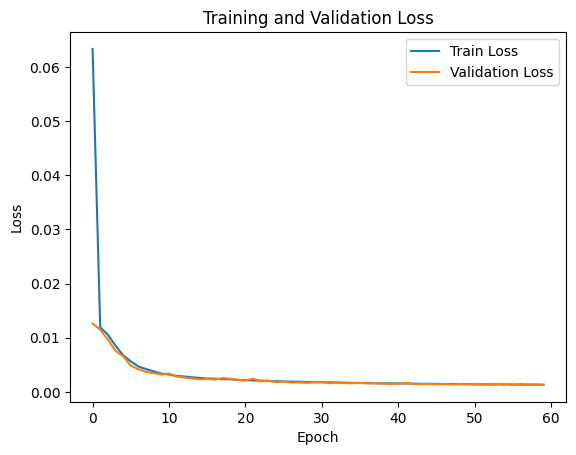

/tmp/ipykernel_496378/2421844753.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))


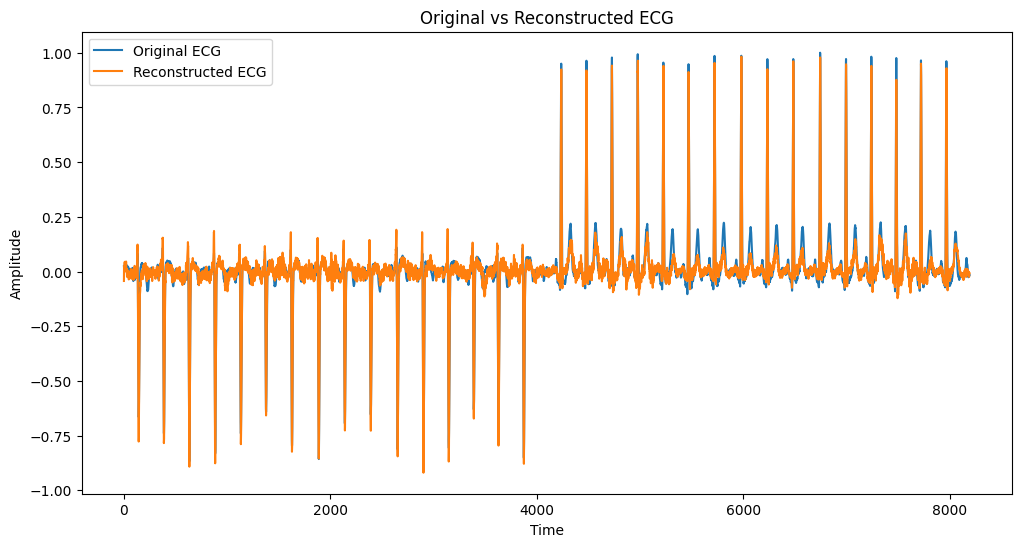

In [30]:
#EXECUTAR MODELO

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# Se ainda não estiver carregado, use np.load() ou outra forma de carregar seus dados
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
print("Formato original de X:", X.shape)
epsilon = 1e-8
X = X / (np.max(np.abs(X), axis=1, keepdims=True) + epsilon)

print("Formato antes do reshape:", X.shape)
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("Formato após o reshape:", X.shape)

total_elements = np.prod(X.shape)
print("Número total de elementos:", total_elements)
# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Convertendo os dados para tensores do PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Criar DataLoaders para treino e teste
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Instanciar o modelo e mover para a GPU se disponível
autoencoder = Autoencoder().to(device)

# Definir o otimizador e a função de perda
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Treinar o modelo
num_epochs = 60
early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = data[0]
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0]
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(autoencoder.state_dict(), 'best_autoencoder.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Plotar a perda de treino e validação
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Carregar o melhor modelo
autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test_tensor[idx].unsqueeze(0)

# Reconstruir o ECG usando o autoencoder
autoencoder.eval()
with torch.no_grad():
    reconstructed_ecg = autoencoder(original_ecg)

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.cpu().numpy().flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.cpu().numpy().flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()